In [129]:
import numpy as np
from lmfit import Model, fit_report, minimize

# Define the function to be fitted
def func(x, a, b, omega, phi, c):
    return a * np.exp(-b * x) * np.sin(omega * x + phi) + c

# Define the residual function
def residual(params, x, y):
    return y - func(x, **params)

# Load data from text files
xdata = np.loadtxt('xdata.txt')
ydata = np.loadtxt('data150_6.txt')

# Define the model to be fitted
model = Model(func)

# Set initial parameter values and bounds
params = model.make_params(a=1.0, b=1.0, omega=1.0, phi=1.0, c=1.0)
params['a'].min = 0.0
params['b'].min = 0.0
params['omega'].min = 0.0
params['phi'].min = -np.pi
params['phi'].max = np.pi
params['a'].max = 5.0
params['b'].max = 5.0
params['omega'].max = 5.0
params['c'].min=0.0
params['c'].max=5.0



# Fit the model to the data using different methods
result_differential_evolution = minimize(residual, params, args=(xdata, ydata), method= 'differential_evolution')
print("\nResults using differential_evolution optimization:")
print(fit_report(result_differential_evolution))




Results using differential_evolution optimization:
[[Fit Statistics]]
    # fitting method   = differential_evolution
    # function evals   = 4719
    # data points      = 6000
    # variables        = 5
    chi-square         = 0.00732178
    reduced chi-square = 1.2213e-06
    Akaike info crit   = -81688.4958
    Bayesian info crit = -81654.9982
[[Variables]]
    a:      0.09263027 +/- 1.3397e-04 (0.14%) (init = 1)
    b:      0.18901698 +/- 3.8144e-04 (0.20%) (init = 1)
    omega:  1.75737116 +/- 3.5193e-04 (0.02%) (init = 1)
    phi:    1.82384189 +/- 0.00132724 (0.07%) (init = 1)
    c:      2.59106334 +/- 1.4333e-05 (0.00%) (init = 1)
[[Correlations]] (unreported correlations are < 0.100)
    C(a, b)       = +0.7309
    C(omega, phi) = -0.6973
    C(a, phi)     = +0.1938
    C(b, phi)     = +0.1352
    C(a, omega)   = -0.1284


In [131]:
param = [0.09263027, 0.18901698, 1.75737116, 1.82384189, 2.59106334]

def func(x, params):
    a = params[0]
    b = params[1]
    omega = params[2]
    phi = params[3]
    c = params[4]
    return a * np.exp(-b * x) * np.sin(omega * x + phi) + c

def sigmoid(x):
    return 1 / (1 + np.exp(-x)) - 0.5

# Define the objective function
def objective_function(params, x, y):
    #print(params)
    y_pred = func(x, params)
    error = y - y_pred
    return np.sum(error**2)

scipy_DE = objective_function(param, xdata, ydata)
print('Scipy DE loss: ', scipy_DE)

Scipy DE loss:  0.007321784343082878


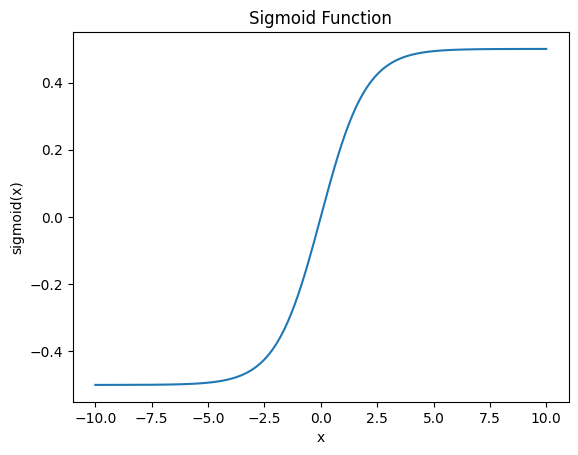

In [102]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x)) - 0.5

x = np.linspace(-10, 10, 1000)
y = sigmoid(x)

plt.plot(x, y)
plt.title("Sigmoid Function")
plt.xlabel("x")
plt.ylabel("sigmoid(x)")
plt.show()


[0.09265002 0.18910859 1.75743747 1.82340457 2.59106145]


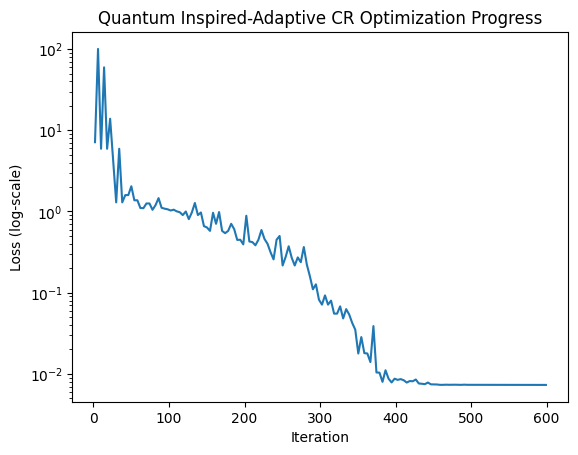

In [121]:
import numpy as np
##  The quantum-inspired DE, positive + negative update, + adaptive CR
max_iterations = 600
# Define the function to be fitted
def func(x, params):
    a = params[0]
    b = params[1]
    omega = params[2]
    phi = params[3]
    c = params[4]
    return a * np.exp(-b * x) * np.sin(omega * x + phi) + c

def sigmoid(x):
    return 1 / (1 + np.exp(-x)) - 0.5

# Define the objective function
def objective_function(params, x, y):
    #print(params)
    y_pred = func(x, params)
    error = y - y_pred
    return np.sum(error**2)

# Define the mutation strategy
# def mutation_strategy(population, F=0.8, CR=0.7):
#     # Select three random members of the population
#     a, b, c = population[np.random.choice(len(population), size=3, replace=False)]
    
#     # Generate a mutated parameter set
#     mutant = a + F * (b - c)
    
#     # Combine the mutated parameter set with the original parameter set
#     trial = np.where(np.random.uniform(size=len(a)) < CR, mutant, a)
    
#     return trial

def mutation_strategy(population, F=0.8, CR=0.7, iters=0):
    # Initialize the trial population
    trial_population = np.zeros_like(population)
    CR_adaptive = 0.5 + 0.3 * sigmoid(iters/max_iterations*10)
    # Loop over each individual in the population
    for i in range(len(population)):
        # Select three unique individuals from the population
        a, b, c = population[np.random.choice(len(population), size=3, replace=False)]

        # Generate a mutant vector using the DE/rand/1 strategy
        #mutant = np.clip(a + F * (b - c), 0, 5)
        
        neg_part = np.where(b-c < 0, b-c, 0) 
        random_neg = np.random.uniform(neg_part, 0, size=np.shape(neg_part))
        pos_part = np.where(b-c > 0, b-c, 0)
        random_pos = np.random.uniform(0, pos_part, size=np.shape(pos_part))
        
        random_quantum = random_neg + random_pos
        mutant = np.clip(a + F * random_quantum, 0, 5)

        # Select a subset of the parameters for crossover
        crossover_mask = np.random.rand(n_params) < CR_adaptive

        # Create the trial vector by combining the mutant and original vectors
        trial = np.where(crossover_mask, mutant, population[i])

        # Ensure that the trial vector is different from the original vector
        if np.array_equal(trial, population[i]):
            j = np.random.choice(n_params)
            trial[j] = mutant[j]

        trial_population[i] = trial

    return trial_population


# Load data from text files
xdata = np.loadtxt('xdata.txt')
ydata = np.loadtxt('data150_6.txt')

# Initialize the population
pop_size = 15
n_params = 5

from pyDOE import lhs
# Latin Hypercube Sampling
# Define the bounds of the parameter space
param_bounds = [(0, 5), (0, 5), (-np.pi, np.pi), (0, 5), (0, 5)]

# Generate an LHS sample of size pop_size
lhs_samples = lhs(len(param_bounds), samples=pop_size, criterion='maximin')

# Scale the LHS sample to the parameter bounds
population = np.zeros((pop_size, len(param_bounds)))
for i, bounds in enumerate(param_bounds):
    population[:, i] = bounds[0] + lhs_samples[:, i] * (bounds[1] - bounds[0])

#population = np.random.uniform(low=0, high=5, size=(pop_size, n_params))

def convergence_criterion_met(param):
    if np.min(param) < 5e-3:
        return True
    else:
        return False

# Define the fitness function
def fitness(population):
#     for params in population:
#         print(params)
#     y = objective_function(params, xdata, ydata)
    fitting = [objective_function(params, xdata, ydata) for params in population]  
    return fitting


xaxis = np.linspace(1, max_iterations+1, max_iterations)
loss_list = []
# Generate new populations
for i in range(max_iterations):
    #print('Iter ', i)
    trial_population = mutation_strategy(population, iters=i)
    trial_fitness = fitness(trial_population)
    
    # Select the best parameter set
    best_index = np.argmin(trial_fitness)
    
    if trial_fitness[best_index] < fitness(population)[best_index]:
        population[best_index] = trial_population[best_index]
    loss_list.append(objective_function(population[best_index], xdata, ydata))
    # Check termination criterion
    if convergence_criterion_met(fitness(population)):
        print('Break ')
        break

print(population[best_index])

import matplotlib.pyplot as plt
# Plot the loss values on a log-scale y-axis
plt.semilogy(xaxis[1::4], loss_list[1::4])

# Add axis labels and title
plt.xlabel('Iteration')
plt.ylabel('Loss (log-scale)')
plt.title('Quantum Inspired-Adaptive CR Optimization Progress')

# Show the plot
plt.show()


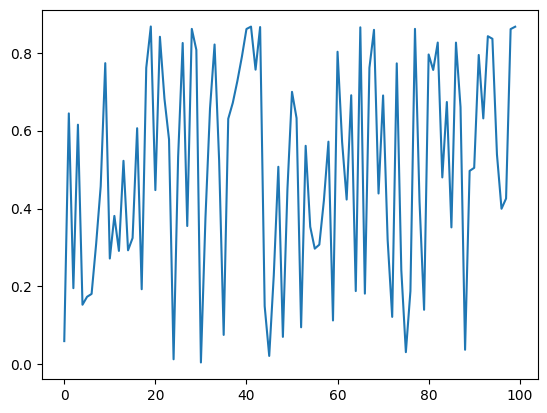

In [13]:
import numpy as np
import matplotlib.pyplot as plt
x = np.random.uniform(0, 1)
def func_F0():
    x = np.random.uniform(0, 1)
    F0 = 2/np.sqrt(3)*np.pi**(-1/4)*(1-x**2)*np.exp(-x**2/2)
    return F0

F0_list = []
for i in range(100):
    F0_list.append(func_F0())
    
plt.plot(np.array(F0_list))

[0.05957600306928043,
 0.6441315869636282,
 0.19547520801504764,
 0.6151745222919541,
 0.15296554488501768,
 0.17329218986447237,
 0.1807688901835433,
 0.30936946064726123,
 0.4572528495055862,
 0.7731606332922444,
 0.27160226205844834,
 0.3810115854793866,
 0.29114977102425516,
 0.5224621387845584,
 0.2926860113818913,
 0.32428217832353223,
 0.606101693032318,
 0.1927660768333042,
 0.7611761897428645,
 0.8673217161741912,
 0.44730658856106154,
 0.8409076661848133,
 0.6815683721278143,
 0.5774612280320666,
 0.012927699590376963,
 0.5327174532279877,
 0.8249304456547322,
 0.35507773378907886,
 0.8611155393255108,
 0.8071597837206,
 0.0047327050850425306,
 0.37630005189066734,
 0.6567646193197685,
 0.821057206870941,
 0.5235384282631105,
 0.07549881992937,
 0.6303498437368575,
 0.6712479729625588,
 0.7269856131496286,
 0.7897379452672013,
 0.8608373672945501,
 0.8669640812291248,
 0.7564778948076277,
 0.86585061881956,
 0.1494251131446004,
 0.02154812742106799,
 0.22877031449096022,
 0.5

Inspried DE  [0.09266477 0.18910248 1.75727822 1.82425376 2.59106498] 0.0073221572179695


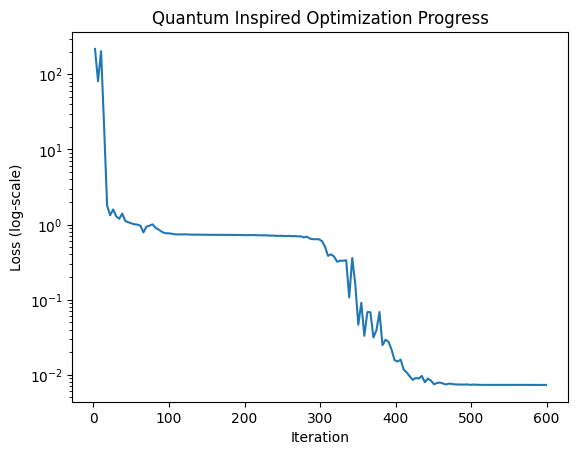

In [40]:
import numpy as np
##  The quantum-inspired DE, positive + negative update + adaptive update

# Define the function to be fitted
def func(x, params):
    a = params[0]
    b = params[1]
    omega = params[2]
    phi = params[3]
    c = params[4]
    return a * np.exp(-b * x) * np.sin(omega * x + phi) + c

def func_F0():
    x = np.random.uniform(0, 1)
    F0 = 2/np.sqrt(3)*np.pi**(-1/4)*(1-x**2)*np.exp(-x**2/2)
    return F0

# Define the objective function
def objective_function(params, x, y):
    #print(params)
    y_pred = func(x, params)
    error = y - y_pred
    return np.sum(error**2)

# Define the mutation strategy
# def mutation_strategy(population, F=0.8, CR=0.7):
#     # Select three random members of the population
#     a, b, c = population[np.random.choice(len(population), size=3, replace=False)]
    
#     # Generate a mutated parameter set
#     mutant = a + F * (b - c)
    
#     # Combine the mutated parameter set with the original parameter set
#     trial = np.where(np.random.uniform(size=len(a)) < CR, mutant, a)
    
#     return trial

def mutation_strategy(population, F=0.8, CR=0.7, success_rate=0.0,success_degree = 0.5):
    # Initialize the trial population
    trial_population = np.zeros_like(population)
    F0 = func_F0()
    F = F0
    
    if success_rate > success_degree:
        CR += 0.05
    else:
        CR -= 0.05
    CR = np.clip(CR, 0.2, 0.9)
    
    # Loop over each individual in the population
    for i in range(len(population)):
        # Select three unique individuals from the population
        a, b, c = population[np.random.choice(len(population), size=3, replace=False)]

        # Generate a mutant vector using the DE/rand/1 strategy
        #mutant = np.clip(a + F * (b - c), 0, 5)
        
        neg_part = np.where(b-c < 0, b-c, 0) 
        random_neg = np.random.uniform(neg_part, 0, size=np.shape(neg_part))
        pos_part = np.where(b-c > 0, b-c, 0)
        random_pos = np.random.uniform(0, pos_part, size=np.shape(pos_part))
        
        random_quantum = random_neg + random_pos
        mutant = np.clip(a + F * random_quantum, 0, 5)

        # Select a subset of the parameters for crossover
        crossover_mask = np.random.rand(n_params) < CR

        # Create the trial vector by combining the mutant and original vectors
        trial = np.where(crossover_mask, mutant, population[i])

        # Ensure that the trial vector is different from the original vector
        if np.array_equal(trial, population[i]):
            j = np.random.choice(n_params)
            trial[j] = mutant[j]

        trial_population[i] = trial

    return trial_population


# Load data from text files
xdata = np.loadtxt('xdata.txt')
ydata = np.loadtxt('data150_6.txt')

# Initialize the population
pop_size = 15
n_params = 5

from pyDOE import lhs
# Latin Hypercube Sampling
# Define the bounds of the parameter space
param_bounds = [(0, 5), (0, 5), (-np.pi, np.pi), (0, 5), (0, 5)]

# Generate an LHS sample of size pop_size
lhs_samples = lhs(len(param_bounds), samples=pop_size, criterion='maximin')

# Scale the LHS sample to the parameter bounds
population = np.zeros((pop_size, len(param_bounds)))
for i, bounds in enumerate(param_bounds):
    population[:, i] = bounds[0] + lhs_samples[:, i] * (bounds[1] - bounds[0])

#population = np.random.uniform(low=0, high=5, size=(pop_size, n_params))

def convergence_criterion_met(param):
    if np.min(param) < 5e-3:
        return True
    else:
        return False

# Define the fitness function
def fitness(population):
#     for params in population:
#         print(params)
#     y = objective_function(params, xdata, ydata)
    fitting = [objective_function(params, xdata, ydata) for params in population]  
    return fitting

max_iterations = 600
xaxis = np.linspace(1, max_iterations+1, max_iterations)
loss_list = []
success_rate = 0.0
# Generate new populations
for i in range(max_iterations):
    #print('Iter ', i)
    trial_population = mutation_strategy(population, success_rate=success_rate)
    trial_fitness = fitness(trial_population)
    origin_fitness = fitness(population)
    # Select the best parameter set
    best_index = np.argmin(trial_fitness)
    
    success_rate = 0.0
    for j in range(pop_size):
        #trial = mutation_strategy(population, CR=CR)
        if trial_fitness[j] < origin_fitness[j]:
            success_rate += 1.0
    success_rate /= pop_size
    
    
#     if trial_fitness[best_index] < fitness(population)[best_index]:
#         population[best_index] = trial_population[best_index]
    
#     update_prob = 0.1
#     # Determine which individuals in the population should be updated
#     update_indices = []
#     for j in range(pop_size):
#         if trial_fitness[j] < fitness(population)[j] and np.random.rand() < update_prob:
#             update_indices.append(j)

    # Update the population with the corresponding trial vectors
    #population[update_indices] = trial_population[update_indices]
    if trial_fitness[best_index] < fitness(population)[best_index]:
        population[best_index] = trial_population[best_index]
                
    loss_list.append(objective_function(population[best_index], xdata, ydata))
    # Check termination criterion
    if convergence_criterion_met(fitness(population)):
        print('Break ')
        break

print('Inspried DE ',population[best_index], loss_list[-1])

import matplotlib.pyplot as plt
# Plot the loss values on a log-scale y-axis
plt.semilogy(xaxis[1::4], loss_list[1::4])

# Add axis labels and title
plt.xlabel('Iteration')
plt.ylabel('Loss (log-scale)')
plt.title('Quantum Inspired Optimization Progress')

# Show the plot
plt.show()


[0.09262998 0.18906704 1.75745308 1.82341872 2.59106292]


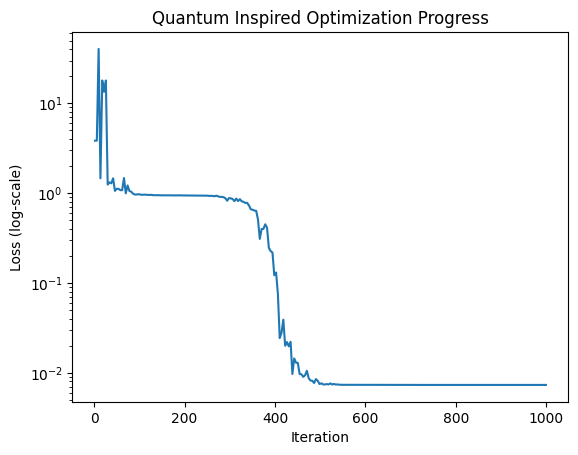

In [125]:
import numpy as np
##  The quantum-inspired only positive DE

# Define the function to be fitted
def func(x, params):
    a = params[0]
    b = params[1]
    omega = params[2]
    phi = params[3]
    c = params[4]
    return a * np.exp(-b * x) * np.sin(omega * x + phi) + c

# Define the objective function
def objective_function(params, x, y):
    #print(params)
    y_pred = func(x, params)
    error = y - y_pred
    return np.sum(error**2)

# Define the mutation strategy
# def mutation_strategy(population, F=0.8, CR=0.7):
#     # Select three random members of the population
#     a, b, c = population[np.random.choice(len(population), size=3, replace=False)]
    
#     # Generate a mutated parameter set
#     mutant = a + F * (b - c)
    
#     # Combine the mutated parameter set with the original parameter set
#     trial = np.where(np.random.uniform(size=len(a)) < CR, mutant, a)
    
#     return trial

def mutation_strategy(population, F=0.8, CR=0.7):
    # Initialize the trial population
    trial_population = np.zeros_like(population)

    # Loop over each individual in the population
    for i in range(len(population)):
        # Select three unique individuals from the population
        a, b, c = population[np.random.choice(len(population), size=3, replace=False)]

        # Generate a mutant vector using the DE/rand/1 strategy
        #mutant = np.clip(a + F * (b - c), 0, 5)
               
        random_quantum = np.random.uniform(0, b - c, size=np.shape(b - c))
        mutant = np.clip(a + F * random_quantum, 0, 5)

        # Select a subset of the parameters for crossover
        crossover_mask = np.random.rand(n_params) < CR

        # Create the trial vector by combining the mutant and original vectors
        trial = np.where(crossover_mask, mutant, population[i])

        # Ensure that the trial vector is different from the original vector
        if np.array_equal(trial, population[i]):
            j = np.random.choice(n_params)
            trial[j] = mutant[j]

        trial_population[i] = trial

    return trial_population


# Load data from text files
xdata = np.loadtxt('xdata.txt')
ydata = np.loadtxt('data150_6.txt')

# Initialize the population
pop_size = 15
n_params = 5

from pyDOE import lhs
# Latin Hypercube Sampling
# Define the bounds of the parameter space
param_bounds = [(0, 5), (0, 5), (-np.pi, np.pi), (0, 5), (0, 5)]

# Generate an LHS sample of size pop_size
lhs_samples = lhs(len(param_bounds), samples=pop_size, criterion='maximin')

# Scale the LHS sample to the parameter bounds
population = np.zeros((pop_size, len(param_bounds)))
for i, bounds in enumerate(param_bounds):
    population[:, i] = bounds[0] + lhs_samples[:, i] * (bounds[1] - bounds[0])

#population = np.random.uniform(low=0, high=5, size=(pop_size, n_params))

def convergence_criterion_met(param):
    if np.min(param) < 5e-3:
        return True
    else:
        return False

# Define the fitness function
def fitness(population):
#     for params in population:
#         print(params)
#     y = objective_function(params, xdata, ydata)
    fitting = [objective_function(params, xdata, ydata) for params in population]  
    return fitting

max_iterations = 1000
xaxis = np.linspace(1, max_iterations+1, max_iterations)
loss_list = []
# Generate new populations
for i in range(max_iterations):
    #print('Iter ', i)
    trial_population = mutation_strategy(population)
    trial_fitness = fitness(trial_population)
    
    # Select the best parameter set
    best_index = np.argmin(trial_fitness)
    
    if trial_fitness[best_index] < fitness(population)[best_index]:
        population[best_index] = trial_population[best_index]
    loss_list.append(objective_function(population[best_index], xdata, ydata))
    # Check termination criterion
    if convergence_criterion_met(fitness(population)):
        print('Break ')
        break

print(population[best_index])

import matplotlib.pyplot as plt
# Plot the loss values on a log-scale y-axis
plt.semilogy(xaxis[1::4], loss_list[1::4])

# Add axis labels and title
plt.xlabel('Iteration')
plt.ylabel('Loss (log-scale)')
plt.title('Quantum Inspired Optimization Progress')

# Show the plot
plt.show()


Original DE [0.09266337 0.18937295 1.75724733 1.82329924 2.59105835] 0.007323849311588686


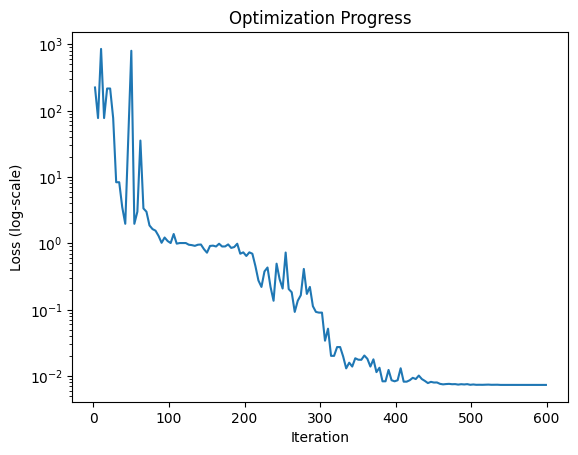

In [137]:
import numpy as np


# Define the function to be fitted
def func(x, params):
    a = params[0]
    b = params[1]
    omega = params[2]
    phi = params[3]
    c = params[4]
    return a * np.exp(-b * x) * np.sin(omega * x + phi) + c

# Define the objective function
def objective_function(params, x, y):
    #print(params)
    y_pred = func(x, params)
    error = y - y_pred
    return np.sum(error**2)

# Define the mutation strategy
# def mutation_strategy(population, F=0.8, CR=0.7):
#     # Select three random members of the population
#     a, b, c = population[np.random.choice(len(population), size=3, replace=False)]
    
#     # Generate a mutated parameter set
#     mutant = a + F * (b - c)
    
#     # Combine the mutated parameter set with the original parameter set
#     trial = np.where(np.random.uniform(size=len(a)) < CR, mutant, a)
    
#     return trial

def mutation_strategy(population, F=0.8, CR=0.7):
    # Initialize the trial population
    trial_population = np.zeros_like(population)

    # Loop over each individual in the population
    for i in range(len(population)):
        # Select three unique individuals from the population
        a, b, c = population[np.random.choice(len(population), size=3, replace=False)]

        # Generate a mutant vector using the DE/rand/1 strategy
        #mutant = np.clip(a + F * (b - c), 0, 5)
        mutant = np.clip(a + F * (b - c), 0, 5)

        # Select a subset of the parameters for crossover
        crossover_mask = np.random.rand(n_params) < CR

        # Create the trial vector by combining the mutant and original vectors
        trial = np.where(crossover_mask, mutant, population[i])

        # Ensure that the trial vector is different from the original vector
        if np.array_equal(trial, population[i]):
            j = np.random.choice(n_params)
            trial[j] = mutant[j]

        trial_population[i] = trial

    return trial_population


# Load data from text files
xdata = np.loadtxt('xdata.txt')
ydata = np.loadtxt('data150_6.txt')

# Initialize the population
pop_size = 15
n_params = 5

from pyDOE import lhs
# Latin Hypercube Sampling
# Define the bounds of the parameter space
param_bounds = [(0, 5), (0, 5), (-np.pi, np.pi), (0, 5), (0, 5)]

# Generate an LHS sample of size pop_size
lhs_samples = lhs(len(param_bounds), samples=pop_size, criterion='maximin')

# Scale the LHS sample to the parameter bounds
population = np.zeros((pop_size, len(param_bounds)))
for i, bounds in enumerate(param_bounds):
    population[:, i] = bounds[0] + lhs_samples[:, i] * (bounds[1] - bounds[0])

#population = np.random.uniform(low=0, high=5, size=(pop_size, n_params))

def convergence_criterion_met(param):
    if np.min(param) < 5e-3:
        return True
    else:
        return False

# Define the fitness function
def fitness(population):
#     for params in population:
#         print(params)
#     y = objective_function(params, xdata, ydata)
    fitting = [objective_function(params, xdata, ydata) for params in population]  
    return fitting

max_iterations = 600
xaxis = np.linspace(1, max_iterations+1, max_iterations)
loss_list = []
# Generate new populations
for i in range(max_iterations):
    #print('Iter ', i)
    trial_population = mutation_strategy(population)
    trial_fitness = fitness(trial_population)
    
    # Select the best parameter set
    best_index = np.argmin(trial_fitness)
    
    if trial_fitness[best_index] < fitness(population)[best_index]:
        population[best_index] = trial_population[best_index]
    loss_list.append(objective_function(population[best_index], xdata, ydata))
    # Check termination criterion
    if convergence_criterion_met(fitness(population)):
        print('Break ')
        break

print('Original DE', population[best_index], loss_list[-1])

import matplotlib.pyplot as plt
# Plot the loss values on a log-scale y-axis
plt.semilogy(xaxis[1::4], loss_list[1::4])

# Add axis labels and title
plt.xlabel('Iteration')
plt.ylabel('Loss (log-scale)')
plt.title('Optimization Progress')

# Show the plot
plt.show()


[0.09263001 0.18906705 1.75745324 1.82341807 2.59106291]


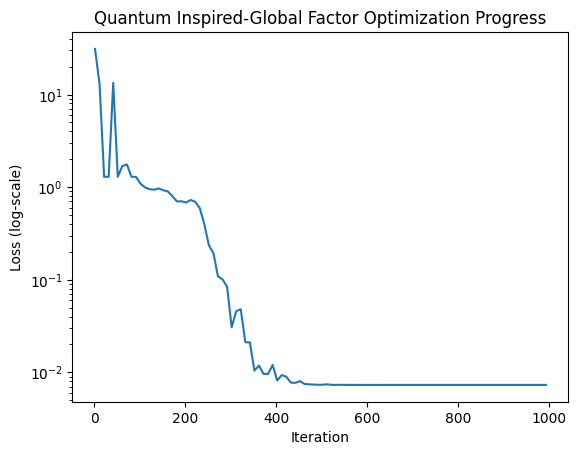

In [87]:
import numpy as np 
##  The quantum-inspired DE & globall factor

global_factor = 1.0

# Define the function to be fitted
def func(x, params):
    a = params[0]
    b = params[1]
    omega = params[2]
    phi = params[3]
    c = params[4]
    return a * np.exp(-b * x) * np.sin(omega * x + phi) + c

# Define the objective function
def objective_function(params, x, y):
    #print(params)
    y_pred = func(x, params)
    error = y - y_pred
    return np.sum(error**2)

# Define the mutation strategy
# def mutation_strategy(population, F=0.8, CR=0.7):
#     # Select three random members of the population
#     a, b, c = population[np.random.choice(len(population), size=3, replace=False)]
    
#     # Generate a mutated parameter set
#     mutant = a + F * (b - c)
    
#     # Combine the mutated parameter set with the original parameter set
#     trial = np.where(np.random.uniform(size=len(a)) < CR, mutant, a)
    
#     return trial

def mutation_strategy(population, F=0.8, CR=0.7):
    # Initialize the trial population
    trial_population = np.zeros_like(population)

    # Loop over each individual in the population
    for i in range(len(population)):
        # Select three unique individuals from the population
        a, b, c = population[np.random.choice(len(population), size=3, replace=False)]

        # Generate a mutant vector using the DE/rand/1 strategy
        #mutant = np.clip(a + F * (b - c), 0, 5)
        random_quantum = np.random.uniform(0, b - c, size=np.shape(b - c))
        mutant = np.clip(a + F * global_factor * random_quantum, 0, 5)

        # Select a subset of the parameters for crossover
        crossover_mask = np.random.rand(n_params) < CR

        # Create the trial vector by combining the mutant and original vectors
        trial = np.where(crossover_mask, mutant, population[i])

        # Ensure that the trial vector is different from the original vector
        if np.array_equal(trial, population[i]):
            j = np.random.choice(n_params)
            trial[j] = mutant[j]

        trial_population[i] = trial

    return trial_population


# Load data from text files
xdata = np.loadtxt('xdata.txt')
ydata = np.loadtxt('data150_6.txt')

# Initialize the population
pop_size = 15
n_params = 5

from pyDOE import lhs
# Latin Hypercube Sampling
# Define the bounds of the parameter space
param_bounds = [(0, 5), (0, 5), (-np.pi, np.pi), (0, 5), (0, 5)]

# Generate an LHS sample of size pop_size
lhs_samples = lhs(len(param_bounds), samples=pop_size, criterion='maximin')

# Scale the LHS sample to the parameter bounds
population = np.zeros((pop_size, len(param_bounds)))
for i, bounds in enumerate(param_bounds):
    population[:, i] = bounds[0] + lhs_samples[:, i] * (bounds[1] - bounds[0])

#population = np.random.uniform(low=0, high=5, size=(pop_size, n_params))

def convergence_criterion_met(param):
    if np.min(param) < 5e-3:
        return True
    else:
        return False

# Define the fitness function
def fitness(population):
#     for params in population:
#         print(params)
#     y = objective_function(params, xdata, ydata)
    fitting = [objective_function(params, xdata, ydata) for params in population]  
    return fitting

max_iterations = 1000
xaxis = np.linspace(1, max_iterations+1, max_iterations)
loss_list = []
# Generate new populations
for i in range(max_iterations):
    #print('Iter ', i)
    trial_population = mutation_strategy(population)
    trial_fitness = fitness(trial_population)
    
    # Select the best parameter set
    best_index = np.argmin(trial_fitness)
    
    if trial_fitness[best_index] < fitness(population)[best_index]:
        population[best_index] = trial_population[best_index]
    loss_list.append(objective_function(population[best_index], xdata, ydata))
    ## update the global factor
    #global_factor = 1.0 + 1*(np.max(trial_fitness) - np.mean(trial_fitness))/(np.max(trial_fitness)-np.min(trial_fitness))
    
    # Check termination criterion
    if convergence_criterion_met(fitness(population)):
        print('Break ')
        break

print(population[best_index], loss_list[-1])

import matplotlib.pyplot as plt
# Plot the loss values on a log-scale y-axis
plt.semilogy(xaxis[1::10], loss_list[1::10])

# Add axis labels and title
plt.xlabel('Iteration')
plt.ylabel('Loss (log-scale)')
plt.title('Quantum Inspired-Global Factor Optimization Progress')

# Show the plot
plt.show()
